In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
import gc
import pickle
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedShuffleSplit

In [2]:
## Function to reduce the memory usage
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics: 
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased from {:5.2f} Mb to {:5.2f} Mb ({:.1f}% reduction)'.format(start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
# read data from file:
train_set0 = pd.read_csv('C:/data/Kaggle_ASHRAE_energy/train_set0.csv')
train_set0 = reduce_mem_usage(train_set0)
train_set1 = pd.read_csv('C:/data/Kaggle_ASHRAE_energy/train_set1.csv')
train_set1 = reduce_mem_usage(train_set1)
train_set2 = pd.read_csv('C:/data/Kaggle_ASHRAE_energy/train_set2.csv')
train_set2 = reduce_mem_usage(train_set2)
train_set3 = pd.read_csv('C:/data/Kaggle_ASHRAE_energy/train_set3.csv')
train_set3 = reduce_mem_usage(train_set3)

Mem. usage decreased from 1603.49 Mb to 467.68 Mb (70.8% reduction)
Mem. usage decreased from 571.30 Mb to 166.63 Mb (70.8% reduction)
Mem. usage decreased from 368.96 Mb to 107.61 Mb (70.8% reduction)
Mem. usage decreased from 173.23 Mb to 50.53 Mb (70.8% reduction)


In [5]:
train_set0.shape, train_set1.shape, train_set2.shape, train_set3.shape

((11676263, 18), (4160090, 18), (2686678, 18), (1261421, 18))

In [6]:
train_set0.head()

,site_id,building_id,primary_use,square_feet,timestamp,airtemp,sealev,dewtemp,windsp,North,West,South,nowind,dewair,month,weekday,hour,meter_reading
0,0,0,0,0.008171,2016-05-20 18:00:00,0.698242,0.606934,0.863770,0.425537,0.0,0.0,0.0,0.0,0.120483,5.0,4.0,18.0,68.219910
1,0,0,0,0.008171,2016-05-20 19:00:00,0.706055,0.597168,0.873535,0.235596,0.0,0.0,0.0,0.0,0.120483,5.0,4.0,19.0,81.423767
2,0,0,0,0.008171,2016-05-20 20:00:00,0.740723,0.595703,0.881836,0.148804,0.0,0.0,0.0,0.0,0.158325,5.0,4.0,20.0,70.020416
3,0,0,0,0.008171,2016-05-20 21:00:00,0.763184,0.589844,0.873535,0.210693,1.0,0.0,0.0,0.0,0.196167,5.0,4.0,21.0,70.620689
4,0,0,0,0.008171,2016-05-20 22:00:00,0.734375,0.584961,0.891602,0.235596,1.0,0.0,0.0,0.0,0.139404,5.0,4.0,22.0,74.021523


### data preparation

In [7]:
# need to rescale the meter_reading:
rob_0 = RobustScaler()
mm_0 = MinMaxScaler()
rob_1 = RobustScaler()
mm_1 = MinMaxScaler()
rob_2 = RobustScaler()
mm_2 = MinMaxScaler()
rob_3 = RobustScaler()
mm_3 = MinMaxScaler()

data scaling for y: log1p --> RobustScaler --> MinMaxScaler

In [8]:
train_set0.meter_reading = mm_0.fit_transform(rob_0.fit_transform(np.log1p(train_set0.meter_reading).values.reshape(-1,1)))
train_set1.meter_reading = mm_1.fit_transform(rob_1.fit_transform(np.log1p(train_set1.meter_reading).values.reshape(-1,1)))
train_set2.meter_reading = mm_2.fit_transform(rob_2.fit_transform(np.log1p(train_set2.meter_reading).values.reshape(-1,1)))
train_set3.meter_reading = mm_3.fit_transform(rob_3.fit_transform(np.log1p(train_set3.meter_reading).values.reshape(-1,1)))

In [9]:
pickle.dump(mm_0, open('mm_0.pkl', 'wb'))
pickle.dump(rob_0, open('rob_0.pkl', 'wb'))
pickle.dump(mm_1, open('mm_1.pkl', 'wb'))
pickle.dump(rob_1, open('rob_1.pkl', 'wb'))
pickle.dump(mm_2, open('mm_2.pkl', 'wb'))
pickle.dump(rob_2, open('rob_2.pkl', 'wb'))
pickle.dump(mm_3, open('mm_3.pkl', 'wb'))
pickle.dump(rob_3, open('rob_3.pkl', 'wb'))

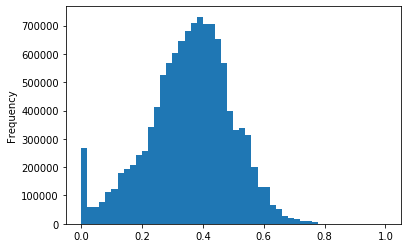

In [10]:
train_set0.meter_reading.plot.hist(bins=50)

In [11]:
train_set0.head()

,site_id,building_id,primary_use,square_feet,timestamp,airtemp,sealev,dewtemp,windsp,North,West,South,nowind,dewair,month,weekday,hour,meter_reading
0,0,0,0,0.008171,2016-05-20 18:00:00,0.698242,0.606934,0.863770,0.425537,0.0,0.0,0.0,0.0,0.120483,5.0,4.0,18.0,0.375416
1,0,0,0,0.008171,2016-05-20 19:00:00,0.706055,0.597168,0.873535,0.235596,0.0,0.0,0.0,0.0,0.120483,5.0,4.0,19.0,0.390884
2,0,0,0,0.008171,2016-05-20 20:00:00,0.740723,0.595703,0.881836,0.148804,0.0,0.0,0.0,0.0,0.158325,5.0,4.0,20.0,0.377692
3,0,0,0,0.008171,2016-05-20 21:00:00,0.763184,0.589844,0.873535,0.210693,1.0,0.0,0.0,0.0,0.196167,5.0,4.0,21.0,0.378437
4,0,0,0,0.008171,2016-05-20 22:00:00,0.734375,0.584961,0.891602,0.235596,1.0,0.0,0.0,0.0,0.139404,5.0,4.0,22.0,0.382547


### network design:
1. Each has 6 inputs, 5 of them are inputs of embedding layers, the rest is numeric input.
2. Categorical embedding for features: building_id, month, hour, etc .
3. Output of them are concatenated as input of main network.

## network parameter search
based on the design of the network, we will search for best number of layers, learning rate, activation, number of neurons

### prepare data for search
due to the hardware limitation of laptop, I will use a small size of data from training data to train the models in my search to improve search efficiency.

### search for number of layers

### search for learning rate and activation

### search for number of neurons

all training data is prepared, now we need to split test_set and new train_set from original train_set

In [12]:
%%time
split = StratifiedShuffleSplit(n_splits=1, test_size = 0.1, random_state=99)
for train_index, test_index in split.split(train_set0, train_set0.building_id):
    strat_train_set0 = train_set0.iloc[train_index]
    strat_test_set0 = train_set0.iloc[test_index]
for train_index, test_index in split.split(train_set1, train_set1.building_id):
    strat_train_set1 = train_set1.iloc[train_index]
    strat_test_set1 = train_set1.iloc[test_index]
for train_index, test_index in split.split(train_set2, train_set2.building_id):
    strat_train_set2 = train_set2.iloc[train_index]
    strat_test_set2 = train_set2.iloc[test_index]
for train_index, test_index in split.split(train_set3, train_set3.building_id):
    strat_train_set3 = train_set3.iloc[train_index]
    strat_test_set3 = train_set3.iloc[test_index]

Wall time: 19.4 s


In [13]:
strat_train_set0.head()

,site_id,building_id,primary_use,square_feet,timestamp,airtemp,sealev,dewtemp,windsp,North,West,South,nowind,dewair,month,weekday,hour,meter_reading
2109112,2,280,1,0.120300,2016-10-21 14:00:00,0.676270,0.553223,0.630371,0.169434,1.0,0.0,0.0,0.0,0.339111,10.0,4.0,14.0,0.461440
125683,0,23,0,0.149292,2016-05-23 13:00:00,0.698242,0.561523,0.863770,0.107422,0.0,0.0,0.0,0.0,0.120483,5.0,0.0,13.0,0.504062
5977866,5,731,0,0.032990,2016-10-20 01:00:00,0.465088,0.554199,0.664551,0.061981,0.0,0.0,0.0,0.0,0.022369,10.0,3.0,1.0,0.165838
6091799,5,744,1,0.055298,2016-10-24 23:00:00,0.503906,0.554199,0.729492,0.210693,1.0,0.0,0.0,0.0,0.005165,10.0,0.0,23.0,0.240517
7026077,8,867,9,0.075012,2016-04-28 18:00:00,0.785156,0.576172,0.846191,0.061981,0.0,0.0,1.0,0.0,0.254639,4.0,3.0,18.0,0.431369


In [14]:
del train_set0
del train_set1
del train_set2
del train_set3
gc.collect()

348

In [15]:
strat_train_set0

,site_id,building_id,primary_use,square_feet,timestamp,airtemp,sealev,dewtemp,windsp,North,West,South,nowind,dewair,month,weekday,hour,meter_reading
2109112,2,280,1,0.120300,2016-10-21 14:00:00,0.676270,0.553223,0.630371,0.169434,1.0,0.0,0.0,0.0,0.339111,10.0,4.0,14.0,0.461440
125683,0,23,0,0.149292,2016-05-23 13:00:00,0.698242,0.561523,0.863770,0.107422,0.0,0.0,0.0,0.0,0.120483,5.0,0.0,13.0,0.504062
5977866,5,731,0,0.032990,2016-10-20 01:00:00,0.465088,0.554199,0.664551,0.061981,0.0,0.0,0.0,0.0,0.022369,10.0,3.0,1.0,0.165838
6091799,5,744,1,0.055298,2016-10-24 23:00:00,0.503906,0.554199,0.729492,0.210693,1.0,0.0,0.0,0.0,0.005165,10.0,0.0,23.0,0.240517
7026077,8,867,9,0.075012,2016-04-28 18:00:00,0.785156,0.576172,0.846191,0.061981,0.0,0.0,1.0,0.0,0.254639,4.0,3.0,18.0,0.431369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7736322,9,951,6,0.118469,2016-01-16 07:00:00,0.481934,0.495605,0.603027,0.000000,0.0,0.0,0.0,1.0,0.110168,1.0,5.0,7.0,0.417256
8982323,13,1100,4,0.199707,2016-05-31 02:00:00,0.698242,0.528809,0.747070,0.235596,1.0,0.0,0.0,0.0,0.244385,5.0,1.0,2.0,0.498278
11294159,15,1393,1,0.173340,2016-05-06 16:00:00,0.561035,0.499268,0.638672,0.235596,0.0,0.0,0.0,0.0,0.177246,5.0,4.0,16.0,0.309043
2826109,3,362,9,0.024109,2016-12-20 06:00:00,0.360107,0.858398,0.432617,0.148804,0.0,0.0,0.0,0.0,0.129028,0.0,1.0,6.0,0.218744


In [16]:
X0 = [strat_train_set0.building_id.values, strat_train_set0.primary_use.values, 
      strat_train_set0.month.values, strat_train_set0.weekday.values, strat_train_set0.hour.values, 
      strat_train_set0.drop(['site_id','building_id','timestamp','meter_reading','dewair'], axis=1).values]
y0 = strat_train_set0.meter_reading.values

X1 = [strat_train_set1.building_id.values, strat_train_set1.primary_use.values, 
      strat_train_set1.month.values, strat_train_set1.weekday.values, strat_train_set1.hour.values, 
      strat_train_set1.drop(['site_id','building_id','timestamp','meter_reading','dewair'], axis=1).values]
y1 = strat_train_set1.meter_reading.values

X2 = [strat_train_set2.building_id.values, strat_train_set2.primary_use.values, 
      strat_train_set2.month.values, strat_train_set2.weekday.values, strat_train_set2.hour.values, 
      strat_train_set2.drop(['site_id','building_id','timestamp','meter_reading','dewair'], axis=1).values]
y2 = strat_train_set2.meter_reading.values

X3 = [strat_train_set3.building_id.values, strat_train_set3.primary_use.values, 
      strat_train_set3.month.values, strat_train_set3.weekday.values, strat_train_set3.hour.values, 
      strat_train_set3.drop(['site_id','building_id','timestamp','meter_reading','dewair'], axis=1).values]
y3 = strat_train_set3.meter_reading.values

In [17]:
X0_test = [strat_test_set0.building_id.values, strat_test_set0.primary_use.values, 
      strat_test_set0.month.values, strat_test_set0.weekday.values, strat_test_set0.hour.values, 
      strat_test_set0.drop(['site_id','building_id','timestamp','meter_reading','dewair'], axis=1).values]
y0_test = strat_test_set0.meter_reading.values

X1_test = [strat_test_set1.building_id.values, strat_test_set1.primary_use.values, 
      strat_test_set1.month.values, strat_test_set1.weekday.values, strat_test_set1.hour.values, 
      strat_test_set1.drop(['site_id','building_id','timestamp','meter_reading','dewair'], axis=1).values]
y1_test = strat_test_set1.meter_reading.values

X2_test = [strat_test_set2.building_id.values, strat_test_set2.primary_use.values, 
      strat_test_set2.month.values, strat_test_set2.weekday.values, strat_test_set2.hour.values, 
      strat_test_set2.drop(['site_id','building_id','timestamp','meter_reading','dewair'], axis=1).values]
y2_test = strat_test_set2.meter_reading.values

X3_test = [strat_test_set3.building_id.values, strat_test_set3.primary_use.values, 
      strat_test_set3.month.values, strat_test_set3.weekday.values, strat_test_set3.hour.values, 
      strat_test_set3.drop(['site_id','building_id','timestamp','meter_reading','dewair'], axis=1).values]
y3_test = strat_test_set3.meter_reading.values

### build neural network model

In [18]:
def build_model():
    
    embeddings = []
    
    input_building_id = layers.Input(shape=(1,), name='input_building_id')
    building_id_emb = layers.Embedding(1449, 20, name = 'building_id_emb')(input_building_id)
    building_id_emb = layers.Flatten()(building_id_emb)
    building_id_emb = layers.BatchNormalization()(building_id_emb)
    building_id_emb = layers.Dropout(0.2)(building_id_emb)
    building_id_emb = layers.Dense(10, activation='relu')(building_id_emb)
    
    embeddings.append(building_id_emb)
    
    input_primary_use = layers.Input(shape=(1,), name='input_primary_use')
    primary_use_emb = layers.Embedding(16, 5, name = 'primary_use_emb')(input_primary_use)
    primary_use_emb = layers.Flatten()(primary_use_emb)
    primary_use_emb = layers.BatchNormalization()(primary_use_emb)
    primary_use_emb = layers.Dropout(0.1)(primary_use_emb)
    primary_use_emb = layers.Dense(2, activation='relu')(primary_use_emb)

    embeddings.append(primary_use_emb)
    
    input_month = layers.Input(shape=(1,), name='input_month')
    month_emb = layers.Embedding(12, 4, name = 'month_emb')(input_month)
    month_emb = layers.Flatten()(month_emb)
    month_emb = layers.BatchNormalization()(month_emb)
    month_emb = layers.Dropout(0.1)(month_emb)
    month_emb = layers.Dense(2, activation='relu')(month_emb)

    embeddings.append(month_emb)
    
    input_weekday = layers.Input(shape=(1,), name='input_weekday')
    weekday_emb = layers.Embedding(7, 3, name = 'month_emb')(input_weekday)
    weekday_emb = layers.Flatten()(weekday_emb)
    weekday_emb = layers.BatchNormalization()(weekday_emb)
    weekday_emb = layers.Dense(2, activation='relu')(weekday_emb)

    embeddings.append(month_emb)
    
    input_hour = layers.Input(shape=(1,), name='input_hour')
    hour_emb = layers.Embedding(24, 6, name = 'hour_emb')(input_hour)
    hour_emb = layers.Flatten()(hour_emb)
    hour_emb = layers.BatchNormalization()(hour_emb)
    hour_emb = layers.Dense(3, activation='relu')(hour_emb)

    embeddings.append(hour_emb)

    
    input_numeric = layers.Input(shape=(13,), name = 'input_numeric')
#    embedding_num = layers.Dense(35)(input_numeric)
    
    embeddings.append(input_numeric)
    
    main_Layers = layers.Concatenate()(embeddings)
    
    # input size = 32
    main_Layers = layers.Dense(50, activation='relu')(main_Layers)
    main_Layers = layers.BatchNormalization()(main_Layers)
    main_Layers = layers.Dropout(0.05)(main_Layers)
    main_Layers = layers.Dense(20, activation='relu')(main_Layers)
    main_Layers = layers.BatchNormalization()(main_Layers)
    main_Layers = layers.Dropout(0.05)(main_Layers)
    main_Layers = layers.Dense(5, activation='relu')(main_Layers)
    main_Layers = layers.BatchNormalization()(main_Layers)
    main_Layers = layers.Dropout(0.05)(main_Layers)
    output = layers.Dense(1)(main_Layers)

    model = tf.keras.Model([input_building_id, input_primary_use, input_month,
                            input_weekday, input_hour, input_numeric], output)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001,beta_1=0.9,beta_2=0.999, epsilon=1e-08), 
                  loss='mse' # tf.keras.losses.mean_squared_error
                  , metrics=['mae']
                 )
    return model

In [19]:
model_meter0 = build_model()
model_meter1 = build_model()
model_meter2 = build_model()
model_meter3 = build_model()

In [20]:
model_meter0.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_building_id (InputLayer)  [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_primary_use (InputLayer)  [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_month (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
building_id_emb (Embedding)     (None, 1, 20)        28980       input_building_id[0][0]          
______________________________________________________________________________________________

### start training the models

In [21]:
history = model_meter0.fit(X0, y0, epochs=60
                           , batch_size=64
#                          , verbose=0
                          )

Train on 10508636 samples
Epoch 1/60
10508636/10508636 [==============================] - 613s 58us/sample - loss: 0.0037 - mae: 0.0372
Epoch 2/60
10508636/10508636 [==============================] - 496s 47us/sample - loss: 0.0028 - mae: 0.0333
Epoch 3/60
10508636/10508636 [==============================] - 495s 47us/sample - loss: 0.0027 - mae: 0.0328
Epoch 4/60
10508636/10508636 [==============================] - 492s 47us/sample - loss: 0.0027 - mae: 0.0326
Epoch 5/60
10508636/10508636 [==============================] - 496s 47us/sample - loss: 0.0027 - mae: 0.0324
Epoch 6/60
10508636/10508636 [==============================] - 534s 51us/sample - loss: 0.0027 - mae: 0.0324
Epoch 7/60
10508636/10508636 [==============================] - 497s 47us/sample - loss: 0.0026 - mae: 0.0323
Epoch 8/60
10508636/10508636 [==============================] - 495s 47us/sample - loss: 0.0026 - mae: 0.0323
Epoch 9/60
10508636/10508636 [==============================] - 496s 47us/sample - loss: 0.002

In [63]:
test_pred = model_meter0.predict(X0_test)

In [64]:
test_rmse = np.sqrt(mean_squared_error(y0_test, test_pred))
print(test_rmse)

0.048293296


In [22]:
history = model_meter1.fit(X1, y1, epochs=60
                           , batch_size=64
#                          , verbose=0
                          )

Train on 3744081 samples
Epoch 1/60
3744081/3744081 [==============================] - 182s 49us/sample - loss: 0.0114 - mae: 0.0684
Epoch 2/60
3744081/3744081 [==============================] - 179s 48us/sample - loss: 0.0080 - mae: 0.0586
Epoch 3/60
3744081/3744081 [==============================] - 181s 48us/sample - loss: 0.0078 - mae: 0.0576
Epoch 4/60
3744081/3744081 [==============================] - 178s 48us/sample - loss: 0.0077 - mae: 0.0570
Epoch 5/60
3744081/3744081 [==============================] - 181s 48us/sample - loss: 0.0076 - mae: 0.0567
Epoch 6/60
3744081/3744081 [==============================] - 180s 48us/sample - loss: 0.0076 - mae: 0.0564
Epoch 7/60
3744081/3744081 [==============================] - 181s 48us/sample - loss: 0.0075 - mae: 0.0562
Epoch 8/60
3744081/3744081 [==============================] - 180s 48us/sample - loss: 0.0075 - mae: 0.0560
Epoch 9/60
3744081/3744081 [==============================] - 181s 48us/sample - loss: 0.0075 - mae: 0.0559
Epo

In [23]:
history = model_meter2.fit(X2, y2, epochs=80
                           , batch_size=64
#                          , verbose=0
                          )

Train on 2418010 samples
Epoch 1/80
2418010/2418010 [==============================] - 113s 47us/sample - loss: 0.0108 - mae: 0.0634
Epoch 2/80
2418010/2418010 [==============================] - 111s 46us/sample - loss: 0.0062 - mae: 0.0513
Epoch 3/80
2418010/2418010 [==============================] - 127s 53us/sample - loss: 0.0060 - mae: 0.0504
Epoch 4/80
2418010/2418010 [==============================] - 127s 53us/sample - loss: 0.0059 - mae: 0.0500
Epoch 5/80
2418010/2418010 [==============================] - 110s 46us/sample - loss: 0.0059 - mae: 0.0497
Epoch 6/80
2418010/2418010 [==============================] - 111s 46us/sample - loss: 0.0058 - mae: 0.0495
Epoch 7/80
2418010/2418010 [==============================] - 110s 46us/sample - loss: 0.0058 - mae: 0.0493
Epoch 8/80
2418010/2418010 [==============================] - 111s 46us/sample - loss: 0.0058 - mae: 0.0492
Epoch 9/80
2418010/2418010 [==============================] - 112s 46us/sample - loss: 0.0058 - mae: 0.0491
Epo

Epoch 76/80
2418010/2418010 [==============================] - 111s 46us/sample - loss: 0.0055 - mae: 0.0478
Epoch 77/80
2418010/2418010 [==============================] - 113s 47us/sample - loss: 0.0055 - mae: 0.0478
Epoch 78/80
2418010/2418010 [==============================] - 115s 48us/sample - loss: 0.0055 - mae: 0.0478
Epoch 79/80
2418010/2418010 [==============================] - 116s 48us/sample - loss: 0.0055 - mae: 0.0478
Epoch 80/80
2418010/2418010 [==============================] - 115s 48us/sample - loss: 0.0055 - mae: 0.0478


In [24]:
history = model_meter3.fit(X3, y3, epochs=100
                           , batch_size=64
#                          , verbose=0
                          )

Train on 1135278 samples
Epoch 1/100
1135278/1135278 [==============================] - 59s 52us/sample - loss: 0.0257 - mae: 0.1068
Epoch 2/100
1135278/1135278 [==============================] - 56s 49us/sample - loss: 0.0148 - mae: 0.0822
Epoch 3/100
1135278/1135278 [==============================] - 56s 49us/sample - loss: 0.0143 - mae: 0.0799
Epoch 4/100
1135278/1135278 [==============================] - 56s 49us/sample - loss: 0.0140 - mae: 0.0787
Epoch 5/100
1135278/1135278 [==============================] - 59s 52us/sample - loss: 0.0139 - mae: 0.0781
Epoch 6/100
1135278/1135278 [==============================] - 62s 54us/sample - loss: 0.0137 - mae: 0.0777
Epoch 7/100
1135278/1135278 [==============================] - 62s 55us/sample - loss: 0.0137 - mae: 0.0774
Epoch 8/100
1135278/1135278 [==============================] - 62s 55us/sample - loss: 0.0136 - mae: 0.0772
Epoch 9/100
1135278/1135278 [==============================] - 62s 55us/sample - loss: 0.0135 - mae: 0.0768
Epo

1135278/1135278 [==============================] - 60s 53us/sample - loss: 0.0129 - mae: 0.0743
Epoch 77/100
1135278/1135278 [==============================] - 60s 53us/sample - loss: 0.0129 - mae: 0.0743
Epoch 78/100
1135278/1135278 [==============================] - 60s 53us/sample - loss: 0.0128 - mae: 0.0743
Epoch 79/100
1135278/1135278 [==============================] - 60s 53us/sample - loss: 0.0129 - mae: 0.0743
Epoch 80/100
1135278/1135278 [==============================] - 60s 52us/sample - loss: 0.0129 - mae: 0.0743
Epoch 81/100
1135278/1135278 [==============================] - 54s 48us/sample - loss: 0.0129 - mae: 0.0742
Epoch 82/100
1135278/1135278 [==============================] - 60s 53us/sample - loss: 0.0128 - mae: 0.0743
Epoch 83/100
1135278/1135278 [==============================] - 60s 53us/sample - loss: 0.0128 - mae: 0.0742
Epoch 84/100
1135278/1135278 [==============================] - 60s 53us/sample - loss: 0.0128 - mae: 0.0743
Epoch 85/100
1135278/1135278 [==

In [25]:
# save models
model_meter0.save('model_meter0.h5')
model_meter1.save('model_meter1.h5')
model_meter2.save('model_meter2.h5')
model_meter3.save('model_meter3.h5')

In [47]:
## list memory taken of objects
import sys
# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']
# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x)) / 1024**2) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('strat_train_set0', 1192.5961570739746),
 ('strat_train_set1', 432.0467233657837),
 ('strat_train_set2', 279.02530097961426),
 ('strat_test_set0', 132.51079273223877),
 ('strat_train_set3', 131.0049648284912),
 ('strat_test_set1', 48.00521183013916),
 ('strat_test_set2', 31.002857208251953),
 ('strat_test_set3', 14.556242942810059),
 ('train_index', 8.661575317382812),
 ('test_index', 0.9624862670898438),
 ('LabelEncoder', 0.001007080078125),
 ('StratifiedShuffleSplit', 0.001007080078125),
 ('MinMaxScaler', 0.00084686279296875),
 ('RobustScaler', 0.00084686279296875),
 ('build_model', 0.00012969970703125),
 ('reduce_mem_usage', 0.00012969970703125),
 ('X0', 0.0001068115234375),
 ('X0_test', 0.0001068115234375),
 ('X1', 0.0001068115234375),
 ('X1_test', 0.0001068115234375),
 ('X2', 0.0001068115234375),
 ('X2_test', 0.0001068115234375),
 ('X3', 0.0001068115234375),
 ('X3_test', 0.0001068115234375),
 ('y0', 9.1552734375e-05),
 ('y0_test', 9.1552734375e-05),
 ('y1', 9.1552734375e-05),
 (

In [26]:
del strat_train_set0
del strat_train_set1
del strat_train_set2
del strat_train_set3
del strat_test_set0
del strat_test_set1
del strat_test_set2
del strat_test_set3
gc.collect()

631

### predict the submit sets

In [4]:
le = pickle.load(open('LabelEncoder_primary_use.pkl', 'rb'))
rob_0 = pickle.load(open('rob_0.pkl', 'rb'))
mm_0 = pickle.load(open('mm_0.pkl', 'rb'))
rob_1 = pickle.load(open('rob_1.pkl', 'rb'))
mm_1 = pickle.load(open('mm_1.pkl', 'rb'))
rob_2 = pickle.load(open('rob_2.pkl', 'rb'))
mm_2 = pickle.load(open('mm_2.pkl', 'rb'))
rob_3 = pickle.load(open('rob_3.pkl', 'rb'))
mm_3 = pickle.load(open('mm_3.pkl', 'rb'))

##### predict submit set with meter 0

In [27]:
# read data from file:
submit_set0 = pd.read_csv('C:/data/Kaggle_ASHRAE_energy/test_set0.csv')
submit_set0 = reduce_mem_usage(submit_set0)

Mem. usage decreased from 3399.69 Mb to 991.58 Mb (70.8% reduction)


In [28]:
submit_set0

,site_id,building_id,primary_use,square_feet,timestamp,airtemp,sealev,dewtemp,windsp,North,West,South,nowind,dewair,month,weekday,hour,row_id
0,0,0,0,0.008171,2017-01-01 00:00:00,0.604980,0.649414,0.756836,0.148804,1.0,0.0,0.0,0.0,0.110168,1.0,6.0,0.0,0
1,0,0,0,0.008171,2017-01-01 01:00:00,0.604980,0.656738,0.774902,0.128052,1.0,0.0,0.0,0.0,0.091248,1.0,6.0,1.0,129
2,0,0,0,0.008171,2017-01-01 02:00:00,0.583008,0.655762,0.774902,0.128052,0.0,0.0,1.0,0.0,0.061951,1.0,6.0,2.0,258
3,0,0,0,0.008171,2017-01-01 03:00:00,0.597168,0.659180,0.782715,0.128052,0.0,0.0,1.0,0.0,0.072266,1.0,6.0,3.0,387
4,0,0,0,0.008171,2017-01-01 04:00:00,0.590820,0.660645,0.782715,0.107422,1.0,0.0,0.0,0.0,0.063660,1.0,6.0,4.0,516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24755755,15,1448,6,0.105164,2018-12-31 19:00:00,0.416992,0.611816,0.594727,0.318115,0.0,0.0,1.0,0.0,0.032715,0.0,0.0,19.0,41497570
24755756,15,1448,6,0.105164,2018-12-31 20:00:00,0.410645,0.605469,0.584961,0.210693,0.0,0.0,1.0,0.0,0.034424,0.0,0.0,20.0,41497820
24755757,15,1448,6,0.105164,2018-12-31 21:00:00,0.410645,0.598145,0.594727,0.256104,0.0,0.0,1.0,0.0,0.024094,0.0,0.0,21.0,41498070
24755758,15,1448,6,0.105164,2018-12-31 22:00:00,0.410645,0.584961,0.603027,0.210693,0.0,0.0,1.0,0.0,0.015488,0.0,0.0,22.0,41498320


In [29]:
# input for submit_set0
X_sub0 = [submit_set0.building_id.values, submit_set0.primary_use.values,
          submit_set0.month.values, submit_set0.weekday.values, submit_set0.hour.values,
          submit_set0.drop(['site_id','building_id','timestamp','dewair','row_id'], axis=1).values]

In [8]:
# load model
model_meter0 = tf.keras.models.load_model('model_meter0.h5')

In [30]:
# predict submit_set0
submit_y0 = model_meter0.predict(X_sub0)

In [31]:
submit_y0 = pd.Series(submit_y0.reshape(-1,))
submit_y0.name = 'meter_reading'

In [32]:
submit_y0 = pd.concat([submit_set0.row_id,submit_y0], axis=1)
submit_y0.columns = ['row_id','meter_reading']

In [33]:
# inverse_transform for submit_y0
submit_y0.meter_reading = np.exp(rob_0.inverse_transform(mm_0.inverse_transform(submit_y0.meter_reading.values.reshape(-1,1))))

In [34]:
submit_y0

,row_id,meter_reading
0,0,50.809746
1,129,50.696861
2,258,49.639946
3,387,49.204128
4,516,49.621357
...,...,...
24755755,41497570,5.708021
24755756,41497820,5.452814
24755757,41498070,5.143563
24755758,41498320,5.048261


In [35]:
# Multiply by 0.2931 to get to model inputs into kWh like the other sites, 
# and 3.4118 to get back to kBTU for scoring
converted_meter0 = submit_y0[submit_set0.site_id ==0].meter_reading.mul(3.4118)

In [36]:
converted_meter0

0          173.352691
1          172.967551
2          169.361568
3          167.874645
4          169.298146
              ...    
1839595    384.552617
1839596    376.541139
1839597    378.972338
1839598    370.395620
1839599    371.999613
Name: meter_reading, Length: 1839600, dtype: float64

In [37]:
# submit_y0.update(converted_meter0)
submit_y0.meter_reading[submit_set0.site_id ==0] = converted_meter0

C:\Users\raymond.guo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [38]:
submit_y0

,row_id,meter_reading
0,0,173.352692
1,129,172.967545
2,258,169.361572
3,387,167.874649
4,516,169.298141
...,...,...
24755755,41497570,5.708021
24755756,41497820,5.452814
24755757,41498070,5.143563
24755758,41498320,5.048261


In [39]:
submit_y0.to_csv('C:/data/Kaggle_ASHRAE_energy/submit_y0.csv', index=False)

In [40]:
del submit_set0
del model_meter0
del converted_meter0
gc.collect()

150583

In [15]:
submit_y0 = pd.read_csv('C:/data/Kaggle_ASHRAE_energy/submit_y0.csv')

In [20]:
submit_y0 = reduce_mem_usage(submit_y0)

Mem. usage decreased from 188.87 Mb to 188.87 Mb (0.0% reduction)


##### predict submit set with meter 1

In [41]:
submit_set1 = pd.read_csv('C:/data/Kaggle_ASHRAE_energy/test_set1.csv')
submit_set1 = reduce_mem_usage(submit_set1)

Mem. usage decreased from 1198.19 Mb to 349.47 Mb (70.8% reduction)


In [42]:
X_sub1 = [submit_set1.building_id.values, submit_set1.primary_use.values,
          submit_set1.month.values, submit_set1.weekday.values, submit_set1.hour.values,
          submit_set1.drop(['site_id','building_id','timestamp','dewair','row_id'], axis=1).values]

In [23]:
model_meter1 = tf.keras.models.load_model('model_meter1.h5')

In [43]:
submit_y1 = model_meter1.predict(X_sub1)

In [44]:
submit_y1 = pd.Series(submit_y1.reshape(-1,))
submit_y1 = pd.concat([submit_set1.row_id,submit_y1], axis=1)
submit_y1.columns = ['row_id','meter_reading']
submit_y1.meter_reading = np.exp(rob_1.inverse_transform(mm_1.inverse_transform(submit_y1.meter_reading.values.reshape(-1,1))))

In [45]:
submit_y1

,row_id,meter_reading
0,8,550.899048
1,137,563.174805
2,266,557.200745
3,395,567.079468
4,524,327.342804
...,...,...
8724955,41497512,4.514752
8724956,41497762,4.327235
8724957,41498012,4.302869
8724958,41498262,4.207999


In [46]:
submit_y1.to_csv('C:/data/Kaggle_ASHRAE_energy/submit_y1.csv', index=False)

In [47]:
del submit_set1
del model_meter1
gc.collect()

157394

In [28]:
submit_y1 = reduce_mem_usage(submit_y1)

Mem. usage decreased from 66.57 Mb to 66.57 Mb (0.0% reduction)


##### predict submit set with meter 2

In [48]:
submit_set2 = pd.read_csv('C:/data/Kaggle_ASHRAE_energy/test_set2.csv')
submit_set2 = reduce_mem_usage(submit_set2)

Mem. usage decreased from 779.55 Mb to 227.37 Mb (70.8% reduction)


In [49]:
X_sub2 = [submit_set2.building_id.values, submit_set2.primary_use.values,
          submit_set2.month.values, submit_set2.weekday.values, submit_set2.hour.values,
          submit_set2.drop(['site_id','building_id','timestamp','dewair','row_id'], axis=1).values]


In [31]:
model_meter2 = tf.keras.models.load_model('model_meter2.h5')

In [50]:
submit_y2 = model_meter2.predict(X_sub2)

In [51]:
submit_y2 = pd.Series(submit_y2.reshape(-1,))
submit_y2 = pd.concat([submit_set2.row_id,submit_y2], axis=1)
submit_y2.columns = ['row_id','meter_reading']
submit_y2.meter_reading = np.exp(rob_2.inverse_transform(mm_2.inverse_transform(submit_y2.meter_reading.values.reshape(-1,1))))

In [52]:
submit_y2

,row_id,meter_reading
0,41539346,8.307504
1,16340505,6.083780
2,16340663,5.521934
3,16340665,6.024232
4,16340745,6.137618
...,...,...
5676475,41497555,132.357376
5676476,41497805,92.343964
5676477,41498055,74.404427
5676478,41498305,71.018433


In [53]:
submit_y2.to_csv('C:/data/Kaggle_ASHRAE_energy/submit_y2.csv', index=False)

In [54]:
del submit_set2
del model_meter2
gc.collect()

150642

In [36]:
submit_y2 = reduce_mem_usage(submit_y2)

Mem. usage decreased from 43.31 Mb to 43.31 Mb (0.0% reduction)


##### predict submit set with meter 3

In [55]:
submit_set3 = pd.read_csv('C:/data/Kaggle_ASHRAE_energy/test_set3.csv')
submit_set3 = reduce_mem_usage(submit_set3)

Mem. usage decreased from 348.87 Mb to 101.75 Mb (70.8% reduction)


In [56]:
X_sub3 = [submit_set3.building_id.values, submit_set3.primary_use.values,
          submit_set3.month.values, submit_set3.weekday.values, submit_set3.hour.values,
          submit_set3.drop(['site_id','building_id','timestamp','dewair','row_id'], axis=1).values]

In [39]:
model_meter3 = tf.keras.models.load_model('model_meter3.h5')

In [57]:
submit_y3 = model_meter3.predict(X_sub3)

In [58]:
submit_y3 = pd.Series(submit_y3.reshape(-1,))
submit_y3 = pd.concat([submit_set3.row_id,submit_y3], axis=1)
submit_y3.columns = ['row_id','meter_reading']
submit_y3.meter_reading = np.exp(rob_3.inverse_transform(mm_3.inverse_transform(submit_y3.meter_reading.values.reshape(-1,1))))

In [59]:
submit_y3

,row_id,meter_reading
0,2260082,1.493137
1,2260145,1.496520
2,2260208,1.632720
3,2260271,1.513978
4,2260334,3.705512
...,...,...
2540395,41497337,4459.645020
2540396,41497587,4480.747070
2540397,41497837,4566.451660
2540398,41498087,4614.110352


In [60]:
submit_y3.to_csv('C:/data/Kaggle_ASHRAE_energy/submit_y3.csv', index=False)

In [61]:
del submit_set3
del model_meter3
gc.collect()

378

In [44]:
submit_y3 = reduce_mem_usage(submit_y3)

Mem. usage decreased from 19.38 Mb to 14.54 Mb (25.0% reduction)


In [13]:
submit_y0 = pd.read_csv('C:/data/Kaggle_ASHRAE_energy/submit_y0.csv')
submit_y0 = reduce_mem_usage(submit_y0)
submit_y1 = pd.read_csv('C:/data/Kaggle_ASHRAE_energy/submit_y1.csv')
submit_y1 = reduce_mem_usage(submit_y1)
submit_y2 = pd.read_csv('C:/data/Kaggle_ASHRAE_energy/submit_y2.csv')
submit_y2 = reduce_mem_usage(submit_y2)
submit_y3 = pd.read_csv('C:/data/Kaggle_ASHRAE_energy/submit_y3.csv')
submit_y3 = reduce_mem_usage(submit_y3)

Mem. usage decreased from 376.12 Mb to 188.06 Mb (50.0% reduction)
Mem. usage decreased from 132.47 Mb to 66.23 Mb (50.0% reduction)
Mem. usage decreased from 38.58 Mb to 14.47 Mb (62.5% reduction)


#### merge all y

In [62]:
submit_y = pd.concat([submit_y0,submit_y1,submit_y2,submit_y3], axis=0)
submit_y = submit_y.sort_values(by='row_id')

In [63]:
submit_y

,row_id,meter_reading
0,0,173.352692
17520,1,118.501900
35040,2,14.333169
52560,3,292.031921
70080,4,1397.875122
...,...,...
24679999,41697595,7.493165
24697519,41697596,6.341680
24715039,41697597,3.898841
24732559,41697598,150.019547


In [64]:
submit_y.to_csv('C:/data/Kaggle_ASHRAE_energy/submit_y.csv', index=False)

In [ ]:
# codes to debug the network when I got all nan output . 

In [27]:
# fetch the output of embedding layer, all nans
building_id_emb1 = tf.keras.Model(inputs = model1.input,
                                outputs = model1.get_layer('building_id_emb').output)
building_id_output = building_id_emb1.predict(X)
building_id_output

array([[[-0.15938824, -0.1609597 ,  0.13235152, ..., -0.10105675,
         -0.11359914,  0.16553003]],

       [[-0.74472386,  0.06896221, -0.7420141 , ..., -0.15583813,
          0.8708445 , -0.24297723]],

       [[-0.6348404 , -0.4213335 , -0.18732052, ..., -0.3587221 ,
         -0.3043011 , -0.33298835]],

       ...,

       [[-0.05055657,  0.08206438,  0.09478991, ..., -0.02927877,
          0.15266207,  0.09116147]],

       [[ 0.09414857, -0.10052757, -0.04715184, ...,  0.0859695 ,
          0.29390404,  0.00264081]],

       [[ 0.06126491, -0.48060998,  0.0963463 , ..., -0.0093626 ,
         -0.02631511, -0.1163187 ]]], dtype=float32)

In [39]:
# fetch the output of embedding layer, all nans
building_id_emb = tf.keras.Model(inputs = model1.input,
                                outputs = model1.get_layer('building_id_emb').output)
building_id_output = building_id_emb.predict(X)
building_id_output

array([[[nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)

In [48]:
building_id_output.shape

(9189087, 1, 20)

In [33]:
# fetch the output of input layer
input_building_id = tf.keras.Model(inputs = model1.input,
                                outputs = model1.get_layer('input_building_id').output)
input_building_id_output = input_building_id.predict(X)
input_building_id_output

array([[1300.],
       [ 197.],
       [ 138.],
       ...,
       [1049.],
       [ 897.],
       [  26.]], dtype=float32)

In [47]:
input_building_id_output.shape

(9189087, 1)

In [84]:
strat_train_set.isnull().any()

site_id          False
building_id      False
0                False
1                False
2                False
3                False
4                False
5                False
6                False
7                False
8                False
9                False
10               False
11               False
12               False
13               False
14               False
15               False
timestamp        False
airtemp          False
sealev           False
dewtemp          False
windsp           False
North            False
West             False
South            False
nowind           False
dewair            True
meter_reading    False
dtype: bool

In [85]:
# there are nan in dewair, which cause all nan output from embedding layer, need to get rid of that, 
# but for now I just abandon that feature.
np.sum(strat_train_set.dewair.isnull())

4037